In [1]:
import numpy as np
import torch

def select_augmentation():
    return 42


def shift(X, y, shift_range=(-20, +20), groups=5, ratio=0.3):
    batch_size = X.shape[0]
    group_size = batch_size // groups
    
    shifted_X = X.clone()
    shifted_y = y.clone()
    
    for g in range(groups):
        start_idx = g * group_size
        end_idx = start_idx + group_size if g < groups - 1 else batch_size
        
        num_to_shift = int((end_idx - start_idx) * ratio)
        shift_indices = np.random.choice(range(start_idx, end_idx), size=num_to_shift, replace=False)
        
        for idx in shift_indices:
            shift = np.random.randint(shift_range[0], shift_range[1] + 1)
            shifted_X[idx] = torch.roll(X[idx], shifts=shift, dims=0)
            shifted_y[idx] = torch.roll(y[idx], shifts=shift, dims=0)
    
    return shifted_X, shifted_y


def temporal_scale(X, y, scale_range=(0.8, 1.2), ratio=0.3, keep_len=True):
    n_voxels, time_points, _ = X.shape
    
    if not keep_len:
        new_length = int(time_points * np.random.uniform(*scale_range))
        print("new_length", new_length)
        scaled_X = torch.nn.functional.interpolate(X.transpose(1,2), size=new_length).transpose(1,2)
        scaled_y = torch.nn.functional.interpolate(y.unsqueeze(1), size=new_length).squeeze(1)
    else:
        scaled_X, scaled_y = X.clone(), y.clone()
    
    for vox_idx in np.random.choice(range(n_voxels), size=int(n_voxels * ratio), replace=False):
        new_length = int(time_points * np.random.uniform(*scale_range)) 
        x_interp = torch.nn.functional.interpolate(X[vox_idx].T.unsqueeze(0), size=new_length).squeeze().T.unsqueeze(-1)
        y_interp = torch.nn.functional.interpolate(y[vox_idx].unsqueeze(0).unsqueeze(0), size=new_length).squeeze()
        
        if keep_len:
            if new_length < time_points:
                repeats = int(np.ceil(time_points / new_length))
                x_interp = x_interp.repeat(repeats, 1)[:time_points]
                y_interp = y_interp.repeat(repeats)[:time_points]
            else:
                x_interp = x_interp[:time_points]  # Only trim if longer
                y_interp = y_interp[:time_points]
            scaled_X[vox_idx] = x_interp
            scaled_y[vox_idx] = y_interp
        else:
            scaled_X[vox_idx] = x_interp
            scaled_y[vox_idx] = y_interp
            
    return scaled_X, scaled_y


def augment_data(X_train, Y_train, shift_range=(-20, +20), amplitude_range=(0.5, 2), noise_std=(0.05,0.1), stretch_ratio=0.6, plot_times=False):
    """
    Augment the data by shifting and scaling the time series data.
    
    Parameters:
    - X_train, Y_train Tensors for the BOLD signal and predicted signals (Y).
    - shift_range: Tuple defining the range for temporal shifts (in number of time steps).
    - amplitude_range: Tuple defining the range for amplitude scaling (scaling factor).
    
    Returns:
    - Augmented tensors for X, Y
    """
    print("Data augmentation")
    # Apply time shifts and amplitude scaling to the training set
    augmented_X = []
    augmented_Y = []
    num_samples = X_train.shape[0]
    if plot_times:
        x,y = X_train[0,:],Y_train[0,:]
        plt.plot(x,label="original")
        plt.plot(y,label='block')
        plt.title("Original signal")

        plt.legend()
        plt.show()

    for i in range(num_samples):
        # 1. Apply random time shift
        newX = X_train[i]
        newY = Y_train[i]
        if False:
            shift = np.random.randint(shift_range[0], shift_range[1] + 1)
            newX = torch.roll(X_train[i], shifts=shift, dims=0)
            newY = torch.roll(Y_train[i], shifts=shift, dims=0)
            if plot_times:
    
                x,y = shifted_X,shifted_Y
                plt.plot(x,label="original")
                plt.plot(y,label='block')            
                plt.title("Signal after shift")
    
                plt.legend()
                plt.show()
        

        if False:
            # 2. Apply random amplitude scaling
            scale_factor = np.random.uniform(amplitude_range[0], amplitude_range[1])
            newX = newX * scale_factor
            newY = newY * scale_factor
            if plot_times:
    
                x,y = scaled_X,scaled_Y
                plt.plot(x,label="original")
                plt.plot(y,label='block')
                plt.title("Signal after scaling")
                plt.legend()
                plt.show()

        if True:
            # 4. Add Gaussian noise
            noise_level=np.random.uniform(noise_std[0], noise_std[1])
            noise_std_value = noise_level*torch.max(newY).item()
            noise_X = torch.normal(mean=0, std=noise_std_value, size=newX.shape, device=newX.device)
            newX = newX + noise_X

        if plot_times:
            x,y = newX,newY
            plt.plot(x,label="original")
            plt.plot(y,label='block')
            plt.title(f"Signal with added noise, noise added: {20*np.log10((noise_level**2/torch.mean(scaled_X**2).item())):.4f}, noise lev{noise_level:.4f}")

            plt.legend()
            plt.show()
            plot_times-=1
        # Store augmented samples
        augmented_X.append(newX)
        augmented_Y.append(newY)

    # Convert lists back to tensors
    augmented_X_tensor = torch.stack(augmented_X)
    augmented_Y_tensor = torch.stack(augmented_Y)
    
    return augmented_X_tensor, augmented_Y_tensor



In [2]:
import torch
from torch import nn
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

nc_file = 'data/derivatives/dataset_MOTOR_60_subjects_both.nc' # hrf convoluted + block, if we want to denoise data
np.random.seed(459345)
dataset = xr.open_dataset(nc_file)

In [3]:
from model_selection import prepare_bold_input, prepare_target_input

In [5]:
DATASET = 'data/derivatives/dataset_MOTOR_60_subjects_both.nc' # hrf convoluted + block, if we want to denoise data

def load_data():
    return xr.open_dataset(DATASET)

from sklearn.model_selection import GroupShuffleSplit

def create_train_test_split(dataset, test_size=0.2, random_state=None):
    subjects = dataset.subject.values
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(splitter.split(subjects, groups=subjects))
    
    train_subjects = subjects[train_idx]
    test_subjects = subjects[test_idx]
    
    return dataset.sel(subject=train_subjects), dataset.sel(subject=test_subjects)

def preprocess_dataset(dataset):
    valid_mask = ~dataset.X.isnull().any(dim='time')
    print(f"Original shape: {dataset.X.shape}")
    
    dataset = dataset.isel(voxel=valid_mask.all(dim='subject'))
    
    print(f"Shape after dropping NaNs: {dataset.X.shape}")
    return dataset

dataset = preprocess_dataset(load_data())

train, test = create_train_test_split(dataset)
X_train, X_test, y_train, y_test = train.X, test.X, train.Y, test.Y

Original shape: (60, 1989, 284)
Shape after dropping NaNs: (60, 1869, 284)


In [6]:
y_train_t = prepare_target_input(y_train)
X_train_t = prepare_bold_input(X_train)

In [10]:
xsh, ysh = shift(X_train_t, y_train_t, shift_range=(-100, 50), ratio=0.7)

In [16]:
xts, yts = temporal_scale(X_train_t, y_train_t, ratio=1)

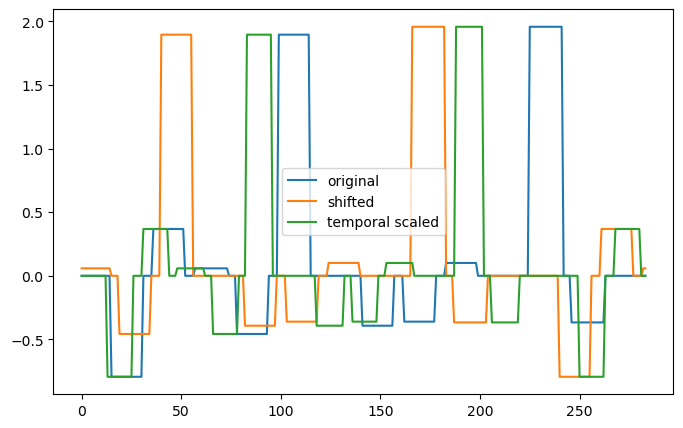

In [19]:
pick = 1
voxels = np.random.choice(xsh.shape[0], size=pick, replace=False)

plt.figure(figsize=(8, 5))
plt.plot(y_train_t[voxels , :].T, label='original');
plt.plot(ysh[voxels, :].T, label='shifted')
plt.plot(yts[voxels, :].T, label='temporal scaled')
plt.legend()
plt.show()

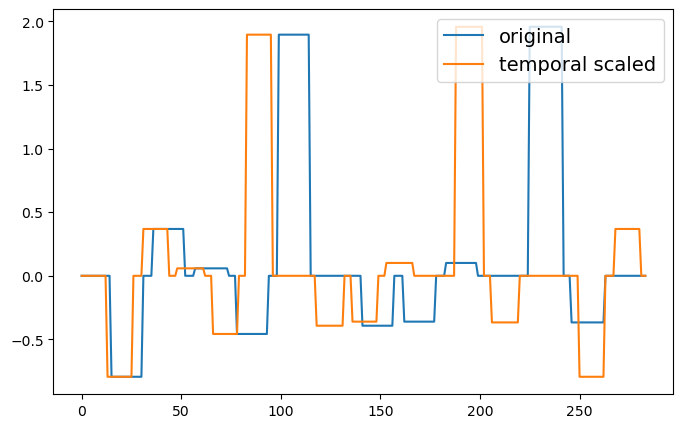

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(y_train_t[voxels , :].T, label='original');
plt.plot(yts[voxels, :].T, label='temporal scaled')
plt.legend(loc='upper right', fontsize=14)
plt.show()

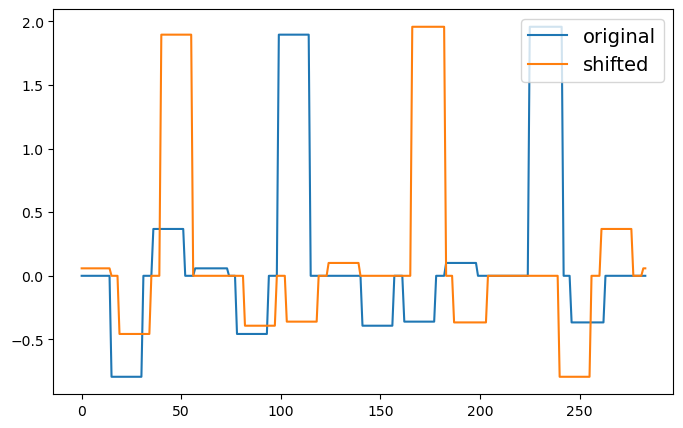

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(y_train_t[voxels , :].T, label='original');
plt.plot(ysh[voxels, :].T, label='shifted')
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [51]:
xa, yx = augment_data(X_train_t, y_train_t)

Data augmentation


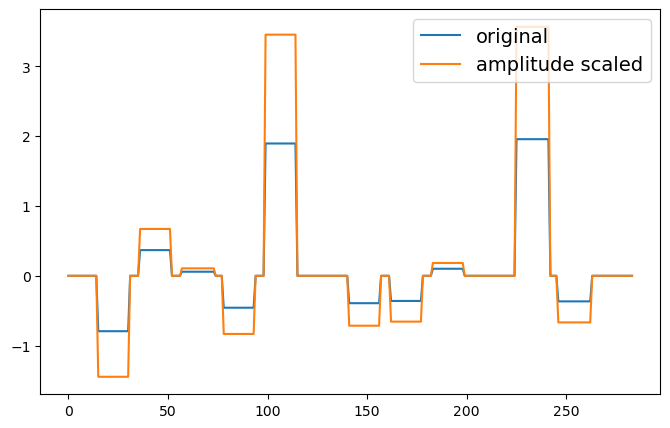

In [54]:
plt.figure(figsize=(8, 5))
plt.plot(y_train_t[voxels , :].T, label='original');
plt.plot(yx[voxels, :].squeeze(-1).T, label='amplitude scaled')
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [48]:
yx[voxels, :].squeeze(-1).T.shape

torch.Size([284, 1])

In [46]:
y_train_t[voxels , :].T.shape

torch.Size([284, 1])

In [58]:
xn, yn = augment_data(X_train_t, y_train_t)

Data augmentation


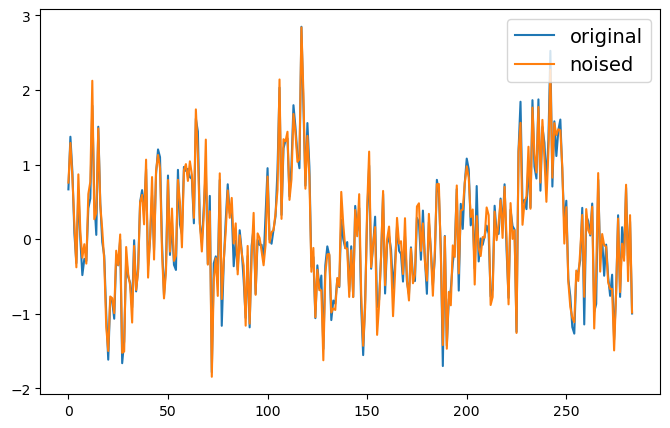

In [60]:
plt.figure(figsize=(8, 5))
plt.plot(X_train_t[voxels , :].squeeze(-1).T, label='original');
plt.plot(xn[voxels, :].squeeze(-1).T, label='noised')
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [2]:
import json
import pandas as pd

def parse_results(filename):
   with open(filename) as f:
       data = json.load(f)
   
   results = []
   for model, metrics in data.items():
       results.append({
           'Model': model,
           'Flat MAE': f"{metrics['flat']['MAE']['avg']:.4f} ± {metrics['flat']['MAE']['std']:.4f}",
           'Flat MSE': f"{metrics['flat']['MSE']['avg']:.4f} ± {metrics['flat']['MSE']['std']:.4f}", 
           'Flat Smoothness': f"{metrics['flat']['smoothness']['avg']:.4f} ± {metrics['flat']['smoothness']['std']:.4f}",
           #'Concat MAE': f"{metrics['concat']['MAE']['avg']:.4f} ± {metrics['concat']['MAE']['std']:.4f}",
           #'Concat MSE': f"{metrics['concat']['MSE']['avg']:.4f} ± {metrics['concat']['MSE']['std']:.4f}",
           #'Concat Smoothness': f"{metrics['concat']['smoothness']['avg']:.4f} ± {metrics['concat']['smoothness']['std']:.4f}"
       })

   return pd.DataFrame(results)


df = parse_results('./models_eval/1734373864_all.json')
print(df.to_string())

FileNotFoundError: [Errno 2] No such file or directory: './models_eval/1734373864_all.json'

In [7]:
import json
import pandas as pd

def parse_task_results(filename):
   with open(filename) as f:
       data = json.load(f)
   
   results = []
   for task, metrics in data.items():
       results.append({
           'Model': model,
           'Flat MAE': f"{metrics['flat']['MAE']['avg']:.4f} ± {metrics['flat']['MAE']['std']:.4f}",
           'Flat MSE': f"{metrics['flat']['MSE']['avg']:.4f} ± {metrics['flat']['MSE']['std']:.4f}", 
           'Flat Smoothness': f"{metrics['flat']['smoothness']['avg']:.4f} ± {metrics['flat']['smoothness']['std']:.4f}",
           #'Concat MAE': f"{metrics['concat']['MAE']['avg']:.4f} ± {metrics['concat']['MAE']['std']:.4f}",
           #'Concat MSE': f"{metrics['concat']['MSE']['avg']:.4f} ± {metrics['concat']['MSE']['std']:.4f}",
           #'Concat Smoothness': f"{metrics['concat']['smoothness']['avg']:.4f} ± {metrics['concat']['smoothness']['std']:.4f}"
       })

   return pd.DataFrame(results)


df = parse_results('../models_eval/1734566886_RNNCNNDeconvolutionRNN_blocky_tasks.json')
print(df.to_string())

        Model         Flat MAE         Flat MSE  Flat Smoothness
0       motor  0.3662 ± 0.0195  0.3217 ± 0.0248  0.1377 ± 0.0146
1    language  0.5398 ± 0.0138  0.5022 ± 0.0199  0.2493 ± 0.0166
2     emotion  0.5526 ± 0.0127  0.5155 ± 0.0137  0.2388 ± 0.0269
3          wm  0.5179 ± 0.0134  0.4855 ± 0.0148  0.2446 ± 0.0165
4  relational  0.5433 ± 0.0134  0.5216 ± 0.0132  0.2380 ± 0.0209
5    gambling  0.5520 ± 0.0133  0.4844 ± 0.0215  0.2288 ± 0.0250


In [9]:
print(parse_results('../models_eval/1734365836_all.json').to_string())

                                 Model         Flat MAE         Flat MSE  Flat Smoothness
0                      BiLSTM_L1Loss()  0.2857 ± 0.0085  0.1837 ± 0.0101  0.4423 ± 0.0106
1                    ConvLSTM_L1Loss()  0.6341 ± 0.0146  0.6780 ± 0.0223  1.3610 ± 0.0333
2              LSTM_attention_L1Loss()  0.6635 ± 0.0142  0.7256 ± 0.0189  1.5037 ± 0.0192
3                    PureConv_L1Loss()  0.4141 ± 0.0100  0.3031 ± 0.0138  0.6661 ± 0.0285
4     RNNCNNDeconvolutionRNN_bi_blocky  0.3593 ± 0.0099  0.2838 ± 0.0127  0.0785 ± 0.0156
5   RNNCNNDeconvolutionRNN_bi_L1Loss()  0.3037 ± 0.0091  0.1946 ± 0.0104  0.4361 ± 0.0204
6                      LSTM1l_L1Loss()  0.6772 ± 0.0142  0.7518 ± 0.0223  1.4783 ± 0.0244
7                      LSTM3l_L1Loss()  0.6657 ± 0.0160  0.7324 ± 0.0248  1.4918 ± 0.0289
8        RNNCNNDeconvolutionRNN_blocky  0.3511 ± 0.0100  0.2730 ± 0.0138  0.0790 ± 0.0134
9      RNNCNNDeconvolutionRNN_L1Loss()  0.2771 ± 0.0086  0.1798 ± 0.0105  0.4097 ± 0.0085
10    RNNC

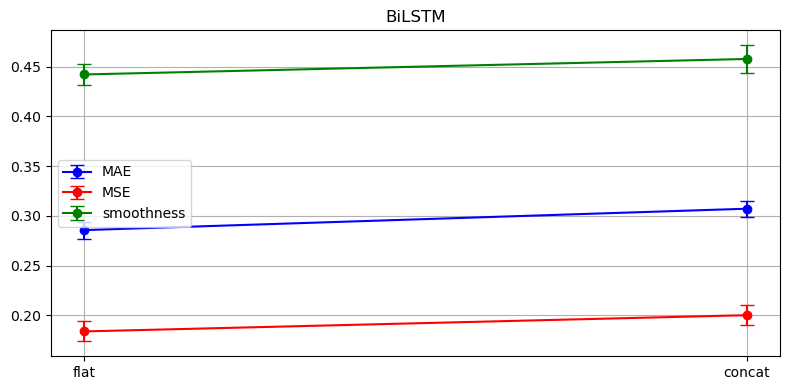

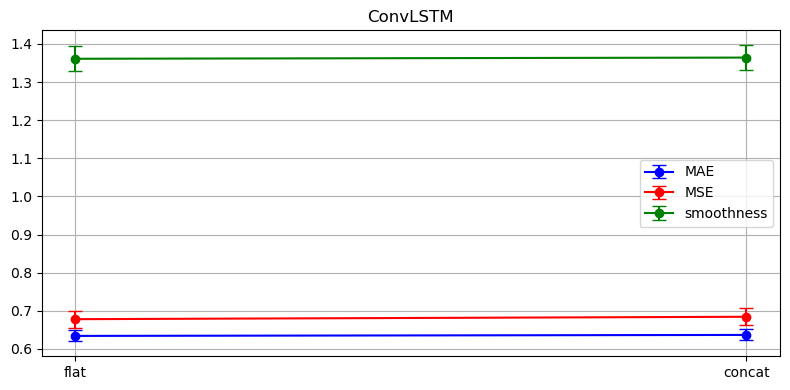

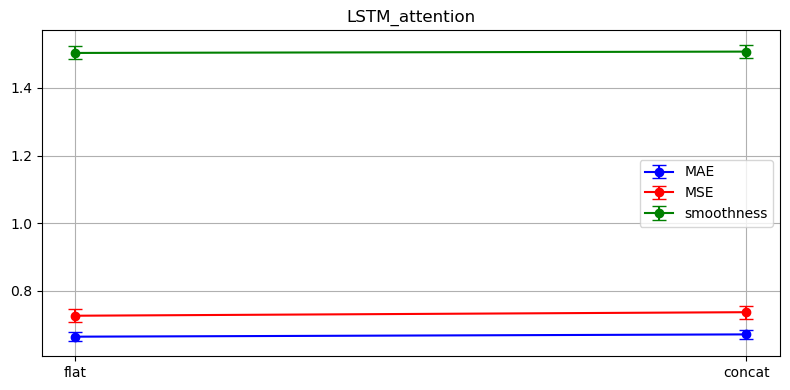

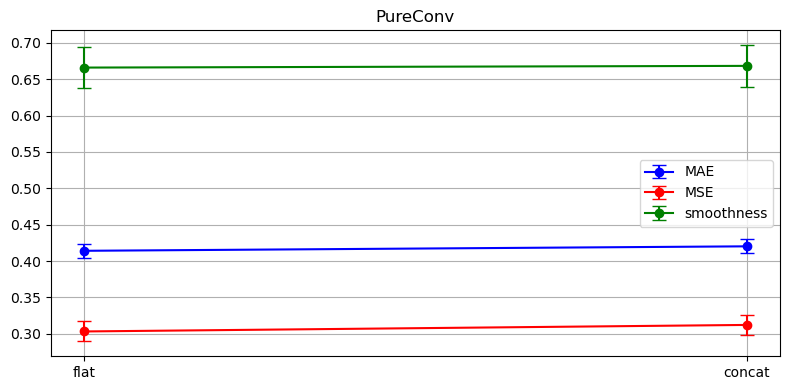

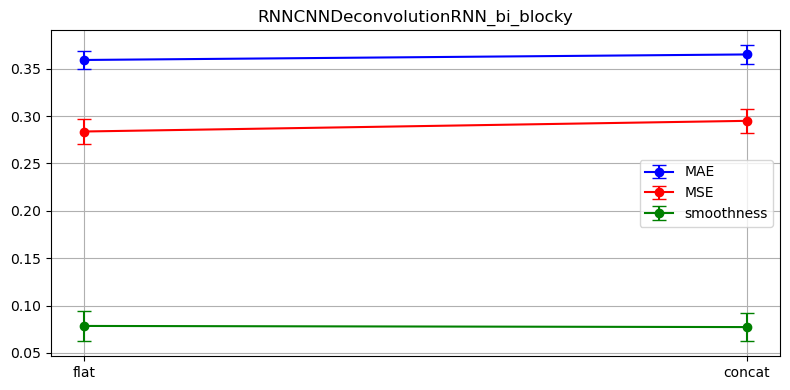

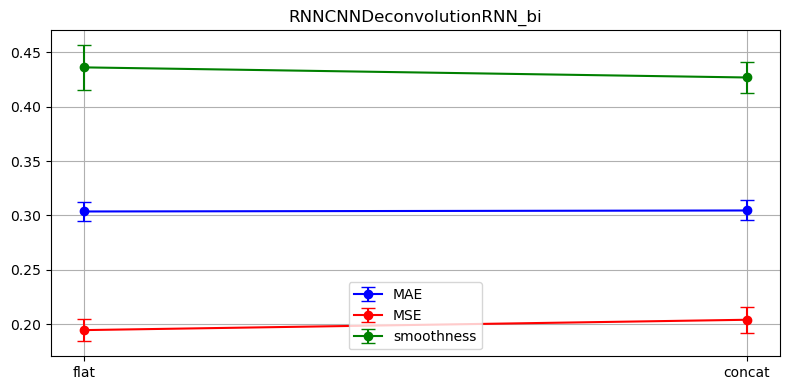

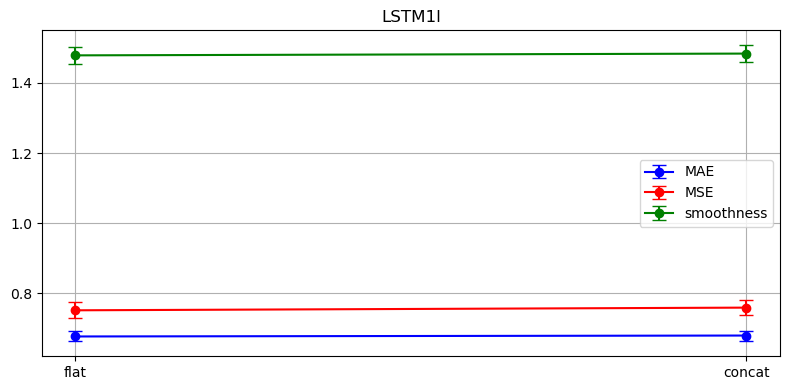

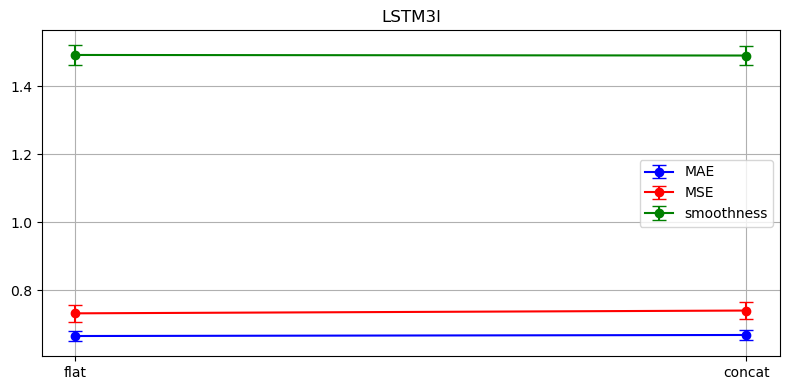

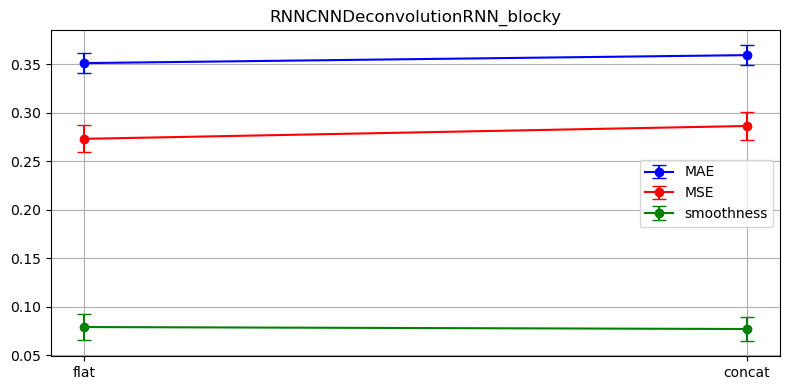

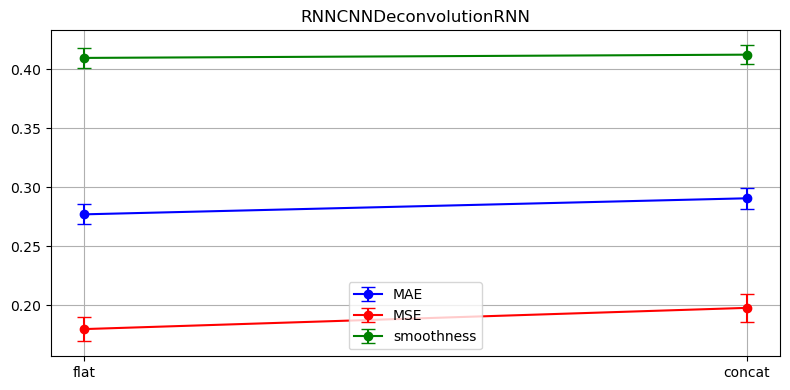

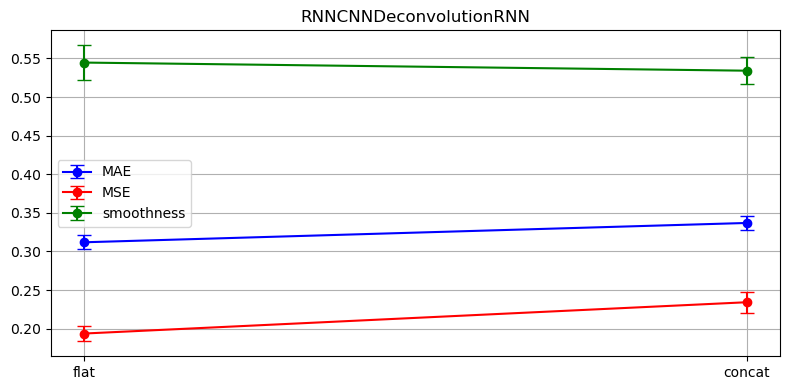

In [75]:
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_model_metrics(filename):
   with open(filename) as f:
       data = json.load(f)
       
   metrics = ['MAE', 'MSE', 'smoothness']
   colors = ['blue', 'red', 'green']
   
   for model in data.keys():
       plt.figure(figsize=(8, 4))
       
       for i, metric in enumerate(metrics):
           flat_mean = data[model]['flat'][metric]['avg']
           flat_std = data[model]['flat'][metric]['std']
           concat_mean = data[model]['concat'][metric]['avg']
           concat_std = data[model]['concat'][metric]['std']
           
           x = [1, 2]  # flat and concat positions
           means = [flat_mean, concat_mean]
           stds = [flat_std, concat_std]
           
           plt.errorbar(x, means, yerr=stds, fmt='o-', 
                       label=metric, color=colors[i], capsize=5)
       
       plt.title(model.replace('_L1Loss()', '').replace('_MSELoss()', ''))
       plt.xticks([1, 2], ['flat', 'concat'])
       plt.legend()
       plt.grid(True)
       plt.tight_layout()
       plt.show()

plot_model_metrics('./models_eval/1734365836_all.json')